# Predicting Recruiter Decisions from Candidate Data Using Logistic Regression with Explainability via LIME and Exploratory Data Analysis

In [218]:
!pip install skimpy

In [219]:
!pip install numpy==1.26.4 \
            scipy==1.11.4 \
            pandas==2.1.4 \
            scikit-learn==1.4.0 \
            matplotlib==3.8.2 \
            seaborn==0.13.1

# Import Libraries

In [220]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from skimpy import skim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import shap
import lime.lime_text
from sklearn.pipeline import make_pipeline
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import warnings
warnings.filterwarnings("ignore")

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load and Glimpse of Dataset

In [222]:
#Load dataset
file_path = r"D:\\hrai\data\AI_Resume_Screening.csv"
df = pd.read_csv(file_path)

# Quick glimpse at the dataset
print("Dataset head:")
print(df.head())

Dataset head:
   Resume_ID              Name                                        Skills  \
0          1        Ashley Ali                      TensorFlow, NLP, Pytorch   
1          2      Wesley Roman  Deep Learning, Machine Learning, Python, SQL   
2          3     Corey Sanchez         Ethical Hacking, Cybersecurity, Linux   
3          4  Elizabeth Carney                   Python, Pytorch, TensorFlow   
4          5        Julie Hill                              SQL, React, Java   

   Experience (Years) Education                Certifications  \
0                  10      B.Sc                           NaN   
1                  10       MBA                     Google ML   
2                   1       MBA  Deep Learning Specialization   
3                   7    B.Tech                 AWS Certified   
4                   4       PhD                           NaN   

                Job Role Recruiter Decision  Salary Expectation ($)  \
0          AI Researcher               Hire

# Skimpy Summary & Missing Data

In [223]:
def quick_summary(df):
    print(f"Shape: {df.shape}")
    print("\nData Types:")
    print(df.dtypes)
    print("\nMissing Values:")
    print(df.isna().sum())
    print("\nNumeric Columns Summary:")
    print(df.describe())
    
quick_summary(df)

Shape: (1000, 11)

Data Types:
Resume_ID                  int64
Name                      object
Skills                    object
Experience (Years)         int64
Education                 object
Certifications            object
Job Role                  object
Recruiter Decision        object
Salary Expectation ($)     int64
Projects Count             int64
AI Score (0-100)           int64
dtype: object

Missing Values:
Resume_ID                   0
Name                        0
Skills                      0
Experience (Years)          0
Education                   0
Certifications            274
Job Role                    0
Recruiter Decision          0
Salary Expectation ($)      0
Projects Count              0
AI Score (0-100)            0
dtype: int64

Numeric Columns Summary:
         Resume_ID  Experience (Years)  Salary Expectation ($)  \
count  1000.000000         1000.000000             1000.000000   
mean    500.500000            4.896000            79994.486000   
std     

In [224]:
# Skimpy summary of dataset to get an overview
#skim(df)

# Check for missing values per column
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Resume_ID                   0
Name                        0
Skills                      0
Experience (Years)          0
Education                   0
Certifications            274
Job Role                    0
Recruiter Decision          0
Salary Expectation ($)      0
Projects Count              0
AI Score (0-100)            0
dtype: int64


#  Basic Target Distribution Plots

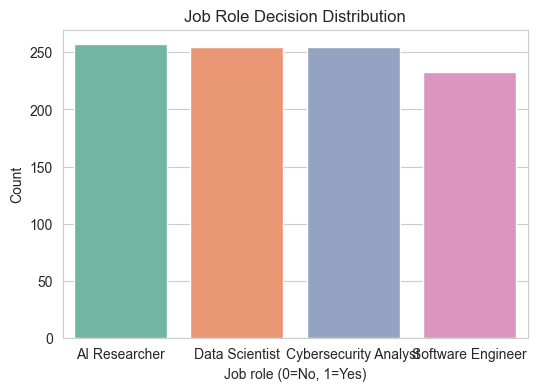

In [225]:
#  Fill missing resume text with empty strings
df['Resume_ID'] = df['Resume_ID'].fillna('')

# Bar plot for hired vs not hired
plt.figure(figsize=(6,4))
sns.countplot(x='Job Role', data=df, palette='Set2')
plt.title('Job Role Decision Distribution')
plt.xlabel('Job role (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()

# CountPlot for Recruiter Decision

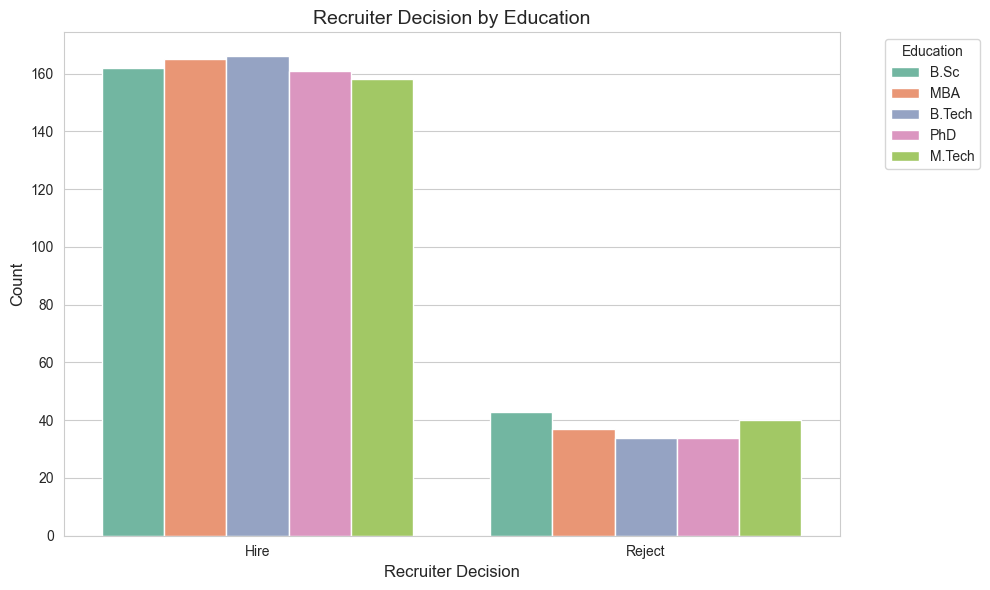

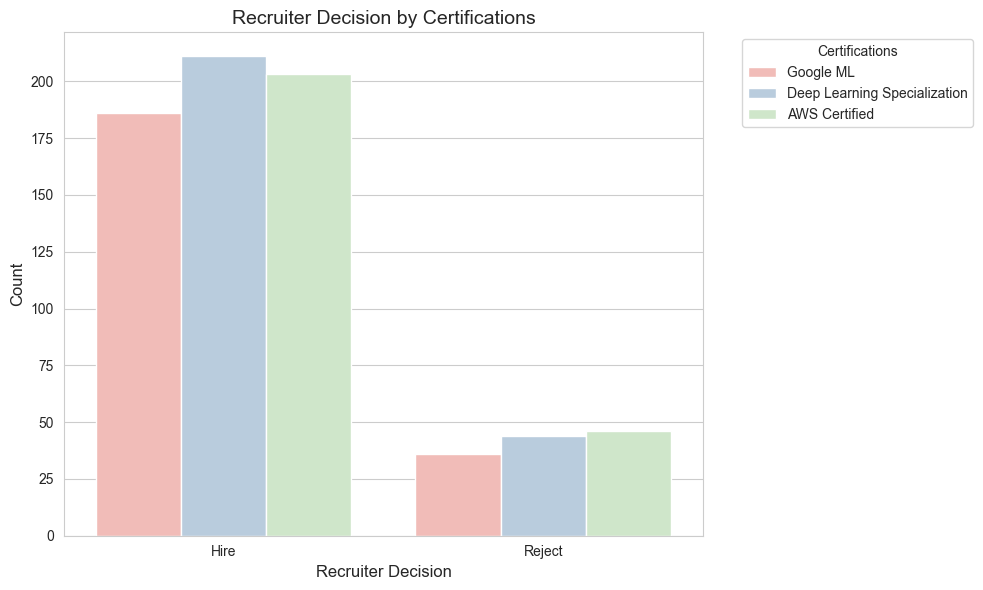

In [226]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

#Recruiter Decision vs Education
plt.figure(figsize=(10, 6))
sns.countplot(x='Recruiter Decision', hue='Education', data=df, palette='Set2')
plt.title('Recruiter Decision by Education', fontsize=14)
plt.xlabel('Recruiter Decision', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Education', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Recruiter Decision vs Certifications
plt.figure(figsize=(10, 6))
sns.countplot(x='Recruiter Decision', hue='Certifications', data=df, palette='Pastel1')
plt.title('Recruiter Decision by Certifications', fontsize=14)
plt.xlabel('Recruiter Decision', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Certifications', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Distribution of Target Variable (Recruiter Decision)

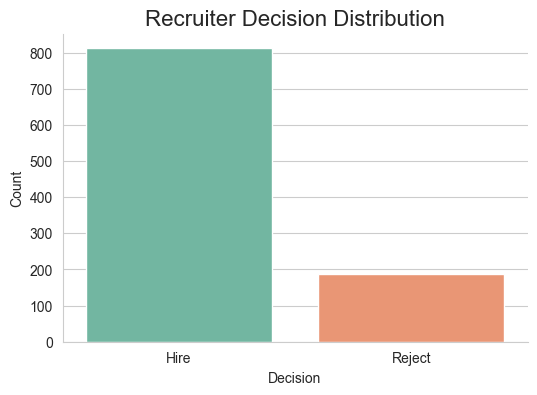

In [227]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Recruiter Decision', palette='Set2')
plt.title('Recruiter Decision Distribution', fontsize=16)
plt.xlabel('Decision')
plt.ylabel('Count')
sns.despine()
plt.show()

# Project Count Distribution by Decision (Strip Plot)

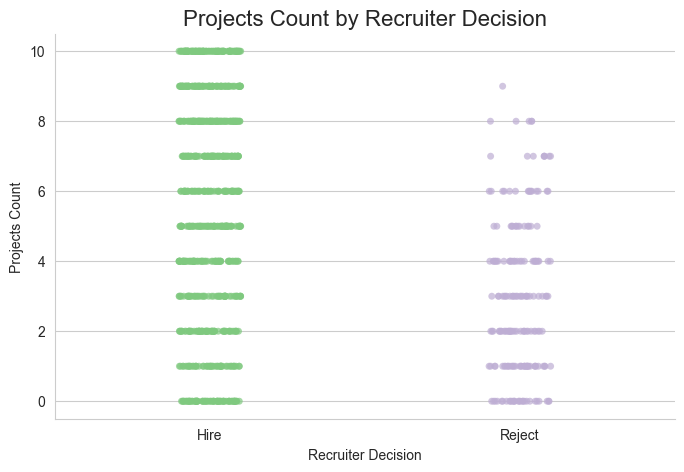

In [228]:
plt.figure(figsize=(8,5))
sns.stripplot(data=df, x='Recruiter Decision', y='Projects Count', jitter=True, palette='Accent', alpha=0.7)
plt.title('Projects Count by Recruiter Decision', fontsize=16)
plt.xlabel('Recruiter Decision')
plt.ylabel('Projects Count')
sns.despine()
plt.show()

# Word Cloud for Skills or Certifications (Text Feature Visualization)

In [229]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


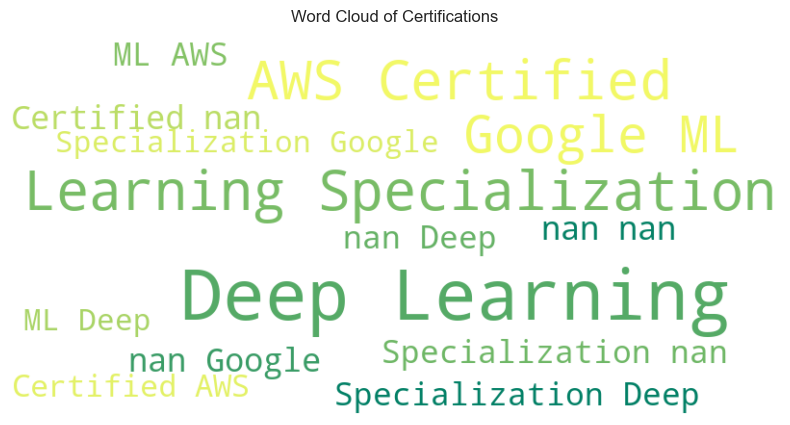

In [230]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(skill for skill in df['Certifications'].astype(str))
wordcloud = WordCloud(background_color='white', colormap='summer', max_words=100, width=800, height=400).generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Certifications')
plt.show()

# Pairplot of Key Features Colored by Decision

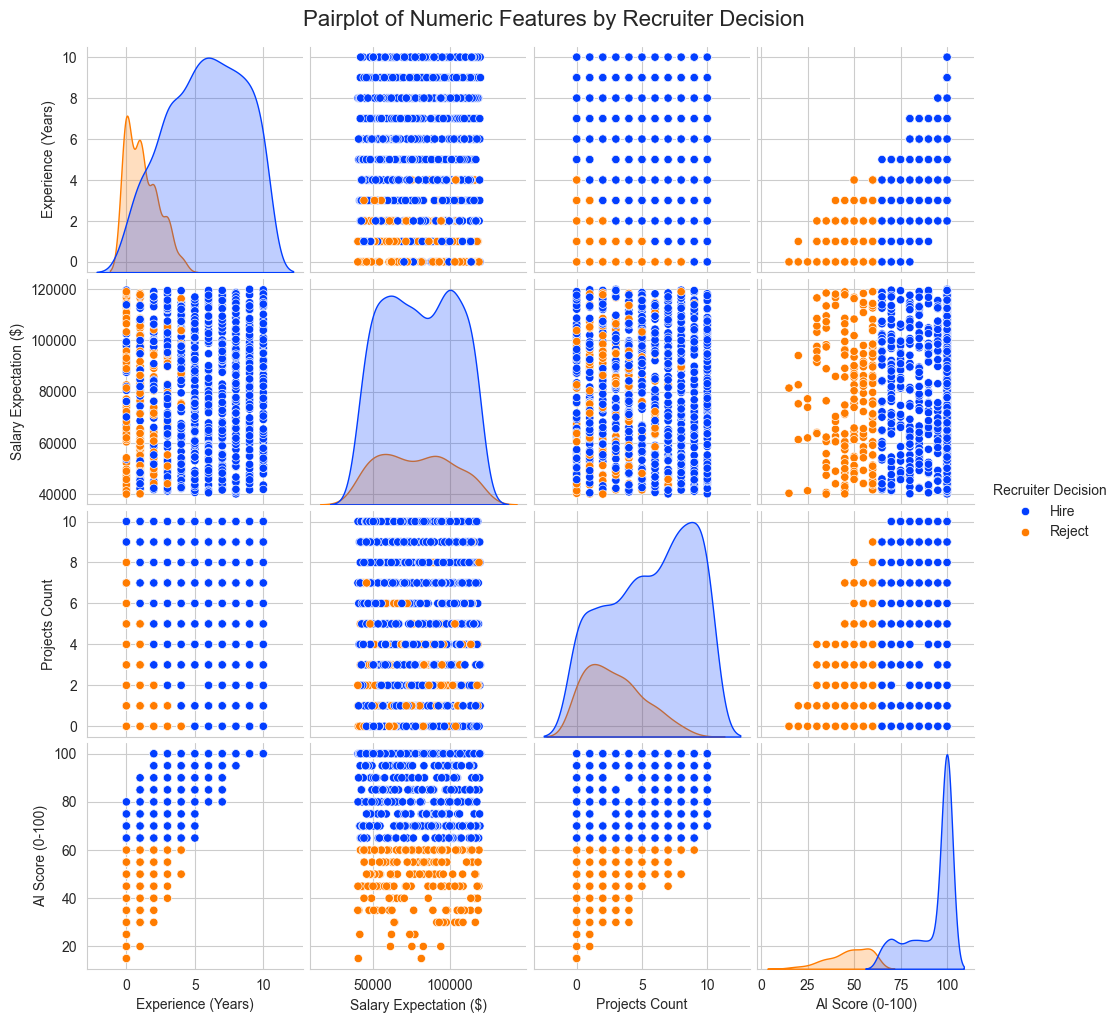

In [231]:
import seaborn as sns
sns.pairplot(df[numeric_cols + ['Recruiter Decision']], hue='Recruiter Decision', palette='bright', diag_kind='kde')
plt.suptitle('Pairplot of Numeric Features by Recruiter Decision', y=1.02, fontsize=16)
plt.show()

#  Education vs Recruiter Decision — Grouped Bar Chart with Percentages

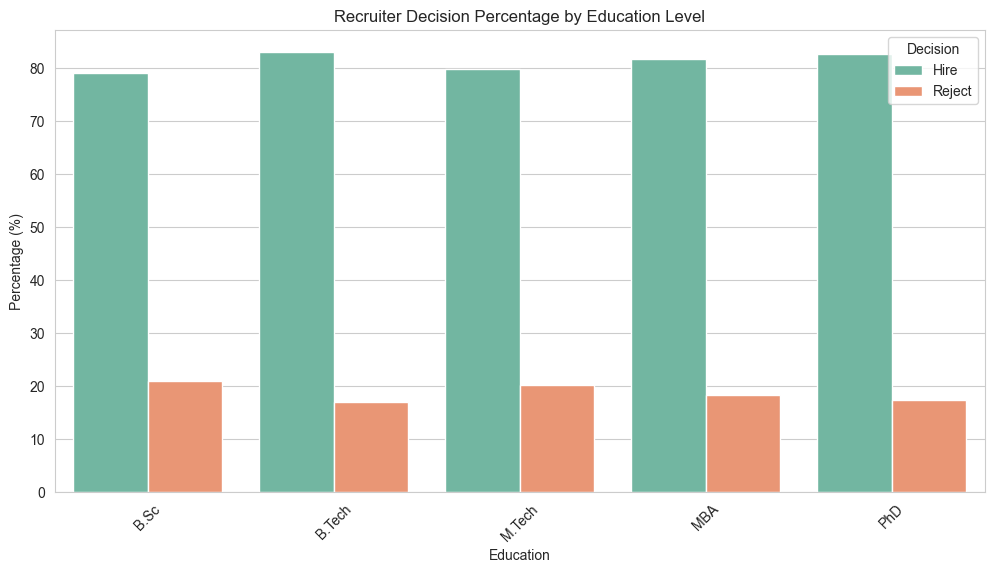

In [232]:
edu_counts = df.groupby(['Education', 'Recruiter Decision']).size().reset_index(name='count')
edu_totals = df.groupby('Education').size().reset_index(name='total')
edu_pct = edu_counts.merge(edu_totals, on='Education')
edu_pct['percent'] = edu_pct['count'] / edu_pct['total'] * 100

plt.figure(figsize=(12,6))
sns.barplot(data=edu_pct, x='Education', y='percent', hue='Recruiter Decision', palette='Set2')
plt.ylabel('Percentage (%)')
plt.title('Recruiter Decision Percentage by Education Level')
plt.legend(title='Decision')
plt.xticks(rotation=45)
plt.show()


# Certifications vs Recruiter Decision (Bar Plot)

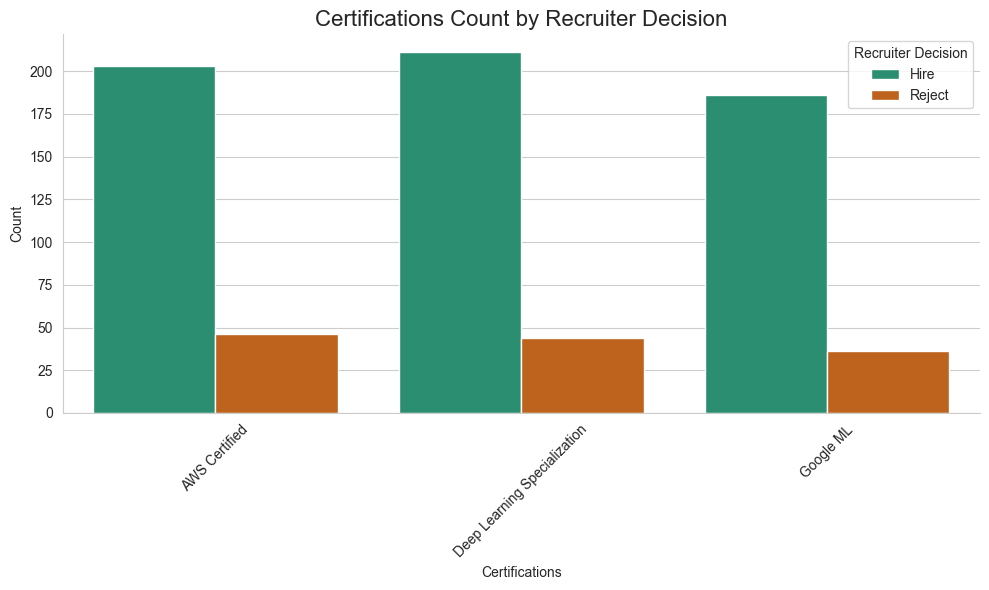

In [233]:
plt.figure(figsize=(10,6))
cert_count = df.groupby(['Certifications', 'Recruiter Decision']).size().reset_index(name='Count')
sns.barplot(data=cert_count, x='Certifications', y='Count', hue='Recruiter Decision', palette='Dark2')
plt.title('Certifications Count by Recruiter Decision', fontsize=16)
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.xlabel('Certifications')
sns.despine()
plt.tight_layout()
plt.show()

# AI Score by Recruiter Decision (KDE Plot)

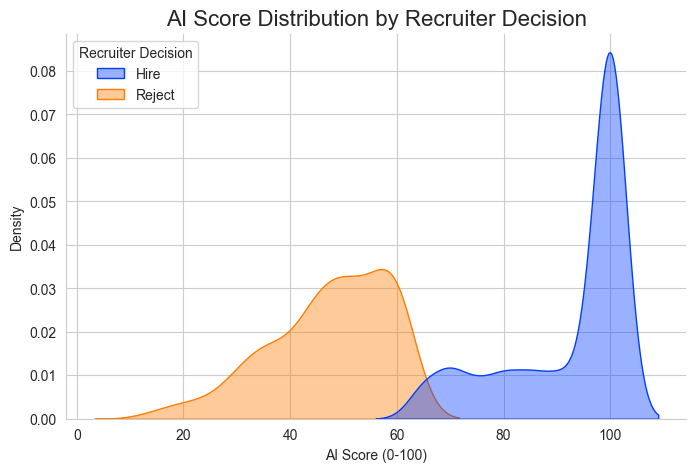

In [234]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=df, x='AI Score (0-100)', hue='Recruiter Decision', fill=True, common_norm=False, palette='bright', alpha=0.4)
plt.title('AI Score Distribution by Recruiter Decision', fontsize=16)
plt.xlabel('AI Score (0-100)')
plt.ylabel('Density')
sns.despine()
plt.show()

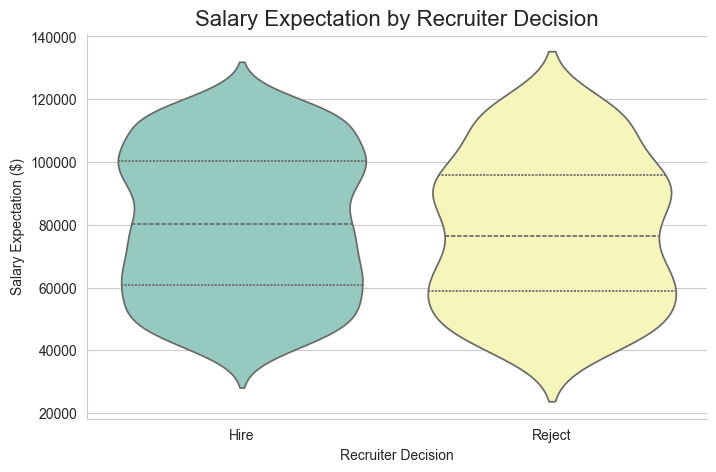

In [235]:
plt.figure(figsize=(8,5))
sns.violinplot(data=df, x='Recruiter Decision', y='Salary Expectation ($)', palette='Set3', inner='quartile')
plt.title('Salary Expectation by Recruiter Decision', fontsize=16)
plt.xlabel('Recruiter Decision')
plt.ylabel('Salary Expectation ($)')
sns.despine()
plt.show()

# Experience vs Decision (Boxplot)

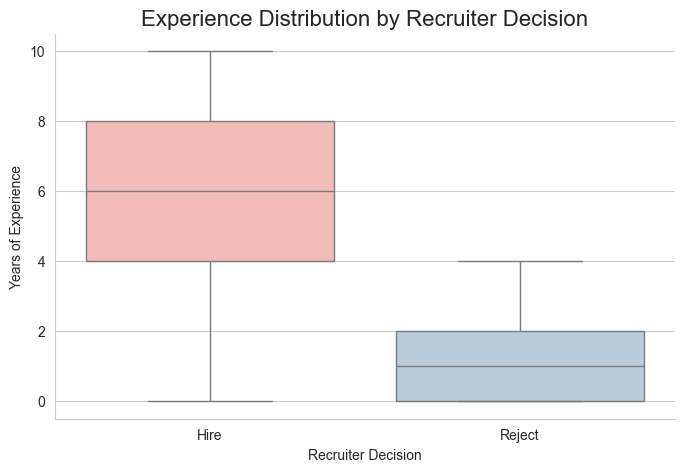

In [236]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='Recruiter Decision', y='Experience (Years)', palette='Pastel1')
plt.title('Experience Distribution by Recruiter Decision', fontsize=16)
plt.xlabel('Recruiter Decision')
plt.ylabel('Years of Experience')
sns.despine()
plt.show()

# Correlation Analysis

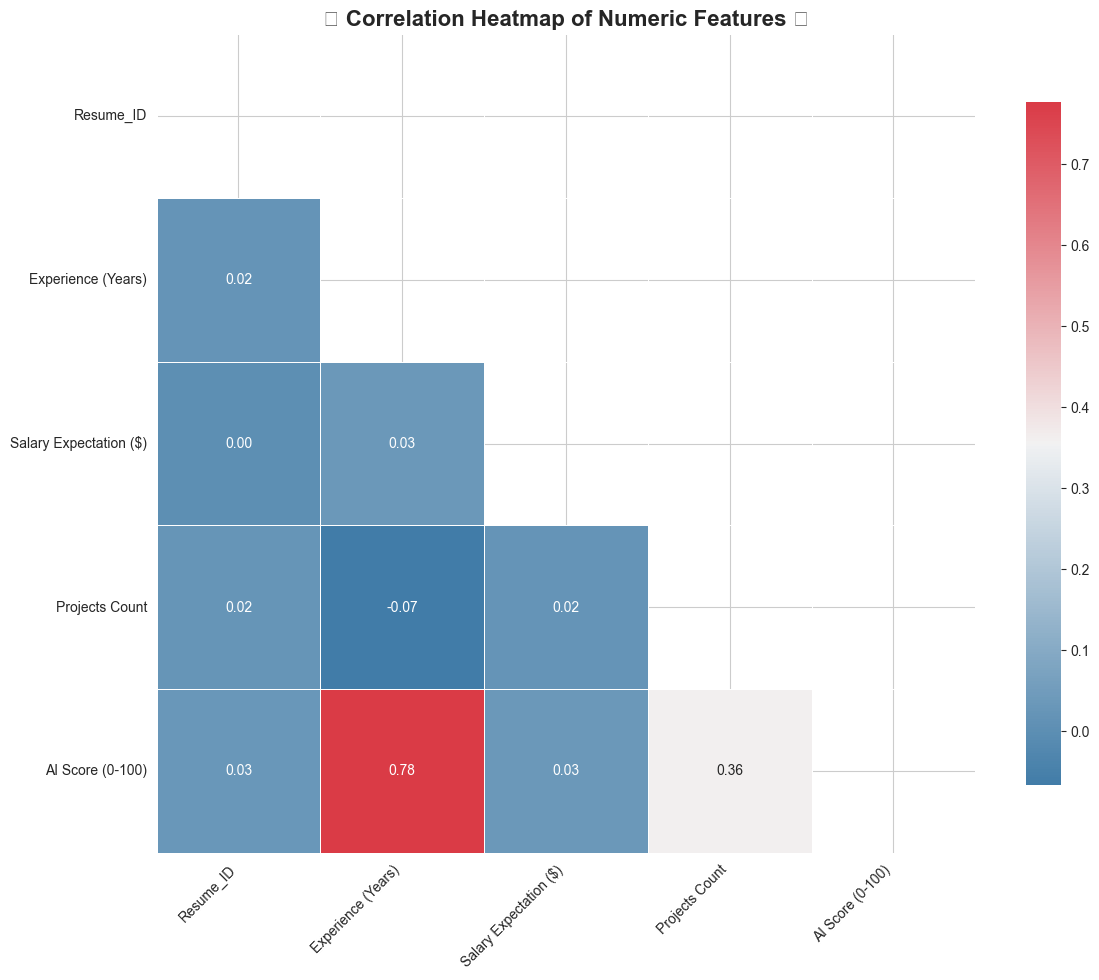

In [237]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Plot if we have enough numeric features
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(12, 10))
    
    # Compute correlation matrix
    corr = numeric_df.corr()
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    # Define a custom color palette
    cmap = sns.diverging_palette(240, 10, as_cmap=True)  # or use "viridis", "YlGnBu"

    # Plot heatmap
    sns.heatmap(corr, 
                mask=mask, 
                cmap=cmap, 
                annot=True, 
                fmt='.2f', 
                square=True, 
                linewidths=0.5, 
                cbar_kws={"shrink": 0.8}, 
                annot_kws={"size": 10})
    
    plt.title('✨ Correlation Heatmap of Numeric Features ✨', fontsize=16, weight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()


# TF-IDF Vectorization and Train-Test Split

In [238]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Choose a real text-based column 
text_column = 'Skills'  

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df[text_column].astype(str))  

# Set a proper target — for example: "Recruiter Decision"
y = df['Recruiter Decision'] 

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Summary
print(f"Train set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"TF-IDF feature size: {X_train.shape[1]}")

Train set size: 800 samples
Test set size: 200 samples
TF-IDF feature size: 15


# Train Machine Learning Models

✅ Accuracy: 0.98

📊 Classification Report:

              precision    recall  f1-score   support

        Hire       0.98      1.00      0.99       162
      Reject       1.00      0.92      0.96        38

    accuracy                           0.98       200
   macro avg       0.99      0.96      0.97       200
weighted avg       0.99      0.98      0.98       200



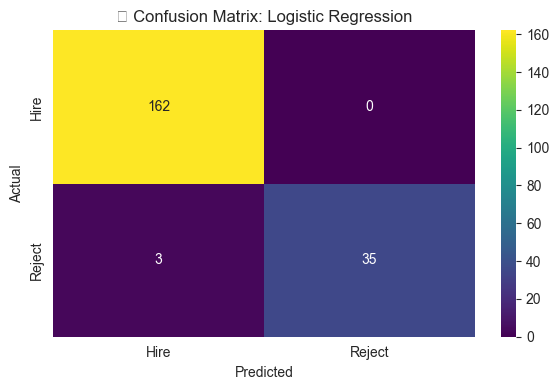

In [239]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Feature and target selection
features = ['Experience (Years)', 'Salary Expectation ($)', 'Projects Count', 'AI Score (0-100)']
le = LabelEncoder()
df['Recruiter Decision Encoded'] = le.fit_transform(df['Recruiter Decision'])

X = df[features]
y = df['Recruiter Decision Encoded']

# Normalize features (important for regularization!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Stratified train-test split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Stronger regularization with C=0.1
model = LogisticRegression(max_iter=1000, C=0.1, penalty='l2')
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'✅ Accuracy: {accuracy:.2f}')
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix with beautiful colors
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('📌 Confusion Matrix: Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


# LIME Explainability

In [240]:
# Convert all resume_text values to string type
df['Resume_ID'] = df['Resume_ID'].astype(str)

X = df['Resume_ID']
y = df['Recruiter Decision']


In [241]:
pip install --upgrade lime

Note: you may need to restart the kernel to use updated packages.


In [242]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import lime.lime_text
from IPython.display import display, HTML


# Define the vectorizer and model pipeline
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Target classes
class_names = df['Recruiter Decision'].unique().tolist()  # e.g. ['Reject', 'Hire']

# Prepare data
X = df['Resume_ID']
y = df['Recruiter Decision']

# Encode target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression(max_iter=1000)
X_train_vec = vectorizer.fit_transform(X_train)
model.fit(X_train_vec, y_train)

# Make pipeline for LIME
pipe = make_pipeline(vectorizer, model)

# Initialize LIME text explainer with class names decoded back to labels
class_names_decoded = le.inverse_transform([0,1])  # Adjust if you have more classes

lime_exp = lime.lime_text.LimeTextExplainer(class_names=class_names_decoded)

# Choose an index from test set to explain
idx = 0
text_instance = X_test.iloc[idx]

print("Resume Text to explain:\n", text_instance)
from IPython.display import display, HTML
# Explain prediction probabilities on that instance
exp = lime_exp.explain_instance(text_instance, pipe.predict_proba, num_features=10)

# Show explanation in notebook
exp.save_to_file('D:\hrai\output\lime_explanation.html')


Resume Text to explain:
 522


In [243]:
import joblib
joblib.dump(model, "D:/hrai/model/hiring_model.pkl")
joblib.dump(vectorizer, "D:/hrai/model/tfidf_vectorizer.pkl")


['D:/hrai/model/tfidf_vectorizer.pkl']